<a href="https://colab.research.google.com/github/Sinjan-Debnath/employee-sentiment-analysis/blob/main/employee_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Section 1: Setup and Library Imports
print("=" * 60)
print("SECTION 1: SETUP AND LIBRARY IMPORTS")
print("=" * 60)

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# For sentiment analysis
from transformers import pipeline

# For predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# For file uploads in Colab
from google.colab import files

print("All libraries imported successfully!")

# --- Data Loading ---
print("\nPlease upload the 'test(in).csv' file.")
uploaded = files.upload()

# Get the filename and load the data
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print(f"\nSuccessfully loaded {file_name} with {len(df)} rows.")

SECTION 1: SETUP AND LIBRARY IMPORTS
All libraries imported successfully!

Please upload the 'test(in).csv' file.


Saving test(in).csv to test(in) (4).csv

Successfully loaded test(in) (4).csv with 2191 rows.


In [2]:
#@title Section 2: Data Preprocessing
print("=" * 60)
print("SECTION 2: DATA PREPROCESSING")
print("=" * 60)

# --- FIX: Manually set the correct column names ---
message_col = 'body'
employee_col = 'from'
date_col = 'date'

print(f"\nUsing columns:")
print(f"Message: {message_col}")
print(f"Employee: {employee_col}")
print(f"Date: {date_col}")

# Clean the data
print("\n" + "=" * 40)
print("DATA CLEANING")
print("=" * 40)

# Handle missing values by dropping rows where key columns are empty
initial_rows = len(df)
df_clean = df.dropna(subset=[message_col, employee_col, date_col]).copy()
rows_after_cleaning = len(df_clean)

print(f"Rows before cleaning: {initial_rows}")
print(f"Rows after cleaning: {rows_after_cleaning}")
print(f"Rows removed: {initial_rows - rows_after_cleaning}")

# Convert date column to datetime objects
try:
    df_clean['date_parsed'] = pd.to_datetime(df_clean[date_col])
    print("Date conversion successful")
except Exception as e:
    print(f"Date conversion failed: {e}")
    df_clean['date_parsed'] = pd.to_datetime(pd.Series([datetime(2023, 1, 1)] * len(df_clean)))

# Extract month and year for easier grouping
df_clean['year_month'] = df_clean['date_parsed'].dt.to_period('M')

print(f"\nDate range: {df_clean['date_parsed'].min()} to {df_clean['date_parsed'].max()}")
print(f"Number of unique employees: {df_clean[employee_col].nunique()}")
print(f"Number of unique months: {df_clean['year_month'].nunique()}")

# Display cleaned data
print("\nFirst few rows of cleaned data:")
print(df_clean[[employee_col, message_col, 'date_parsed', 'year_month']].head())

SECTION 2: DATA PREPROCESSING

Using columns:
Message: body
Employee: from
Date: date

DATA CLEANING
Rows before cleaning: 2191
Rows after cleaning: 2191
Rows removed: 0
Date conversion successful

Date range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00
Number of unique employees: 10
Number of unique months: 24

First few rows of cleaned data:
                      from                                               body  \
0     sally.beck@enron.com  EnronOptions Announcement\n\n\nWe have updated...   
1      eric.bass@enron.com  Marc,\n\nUnfortunately, today is not going to ...   
2     sally.beck@enron.com  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   
3  johnny.palmer@enron.com  we were thinking papasitos (we can meet somewh...   
4  lydia.delgado@enron.com  Since you never gave me the $20 for the last t...   

  date_parsed year_month  
0  2010-05-10    2010-05  
1  2010-07-29    2010-07  
2  2011-07-25    2011-07  
3  2010-03-25    2010-03  
4  2011-05-21    2011-05  


SECTION 3: SENTIMENT LABELING
Initializing sentiment analysis model...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Roberta sentiment model loaded successfully!

Performing sentiment analysis on all messages...

Sentiment analysis completed!

Sentiment Distribution:
sentiment
Neutral     1654
Positive     424
Negative     113
Name: count, dtype: int64


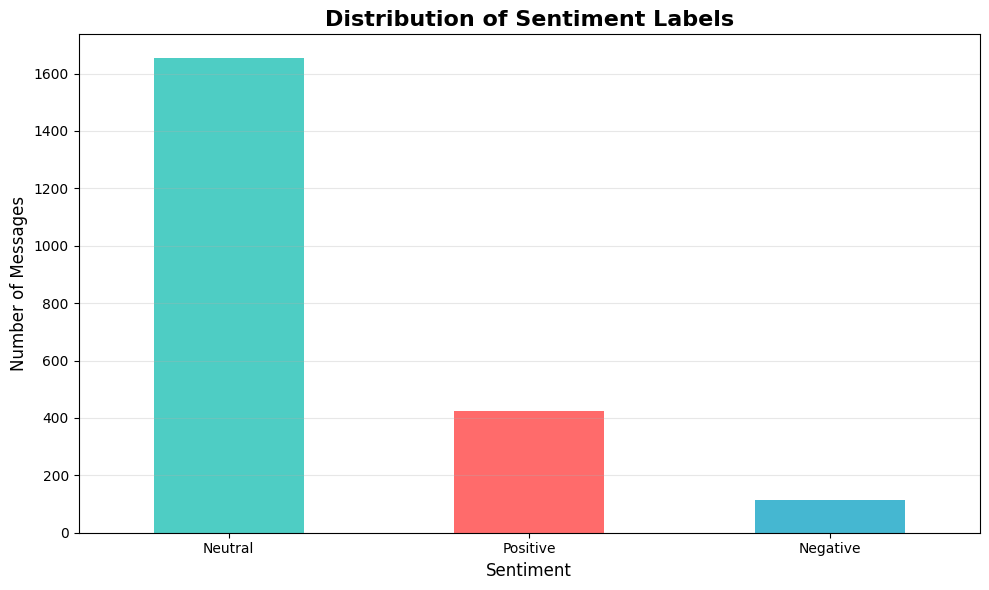

In [3]:
#@title Section 3: Sentiment Labeling using LLM
print("=" * 60)
print("SECTION 3: SENTIMENT LABELING")
print("=" * 60)

print("Initializing sentiment analysis model...")

# Use a pre-trained sentiment analysis model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest"
)
print("Roberta sentiment model loaded successfully!")

def analyze_sentiment(text):
    try:
        truncated_text = str(text)[:512]
        result = sentiment_pipeline(truncated_text)[0]
        label = result['label'].lower()
        if 'positive' in label: return 'Positive'
        elif 'negative' in label: return 'Negative'
        else: return 'Neutral'
    except Exception: return 'Neutral'

print("\nPerforming sentiment analysis on all messages...")

# --- Apply analysis to the entire cleaned dataframe ---
df_final = df_clean.copy()
df_final['sentiment'] = df_final[message_col].apply(analyze_sentiment)

print("\nSentiment analysis completed!")

# --- Plotting Function Definition ---
def plot_sentiment_distribution(df, save_path=None):
    plt.figure(figsize=(10, 6))
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#4ECDC4', '#FF6B6B', '#45B7D1']
    sentiment_counts.plot(kind='bar', color=colors)
    plt.title('Distribution of Sentiment Labels', fontsize=16, fontweight='bold')
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Number of Messages', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- Display Results ---
print("\nSentiment Distribution:")
print(df_final['sentiment'].value_counts())

# --- Function Call to Display Plot ---
plot_sentiment_distribution(df_final)

SECTION 4: EXPLORATORY DATA ANALYSIS
Visualizing sentiment trends over time...


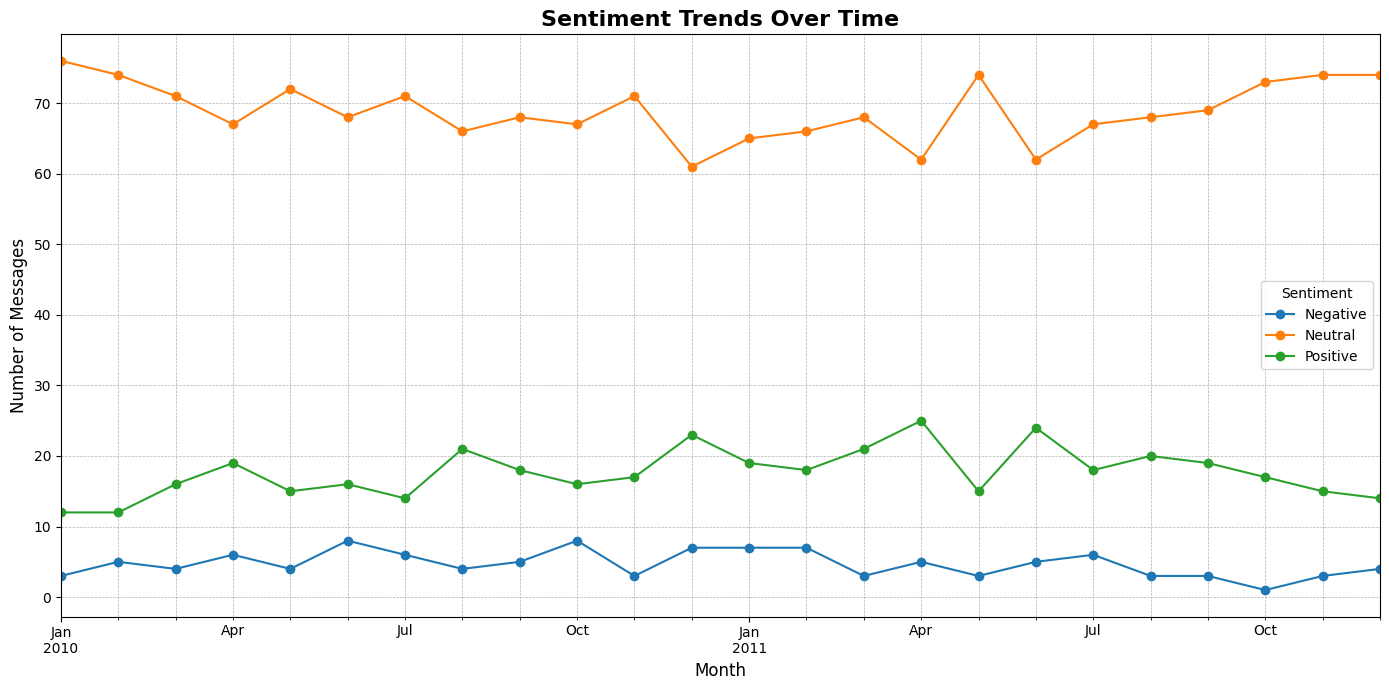


Visualizing message volume by day of the week...


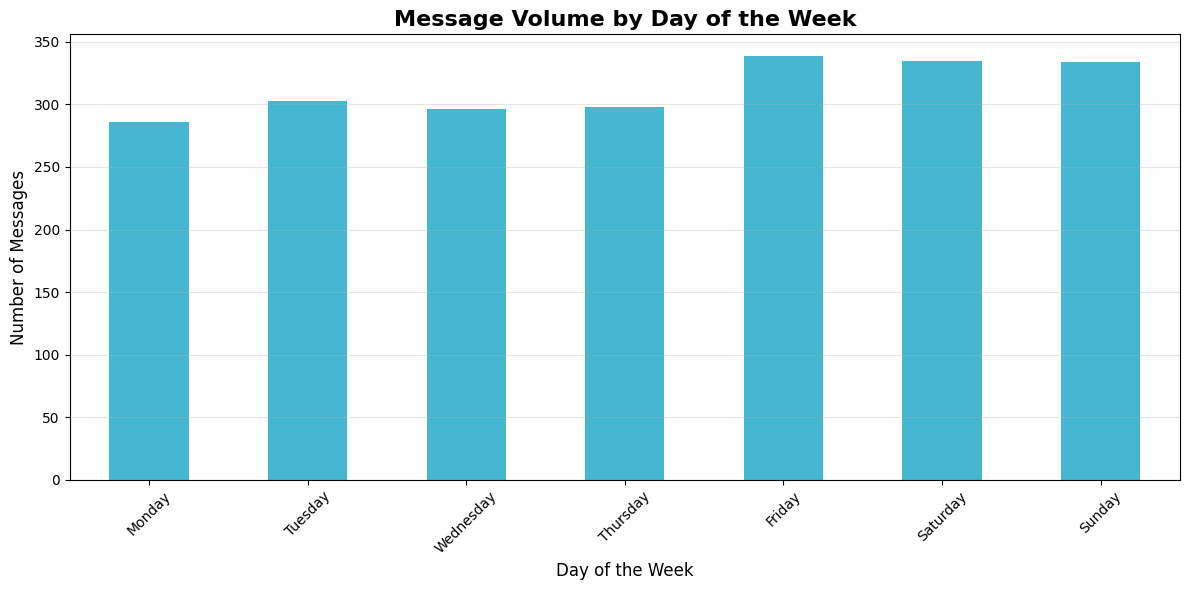


Visualizing distribution of message length...


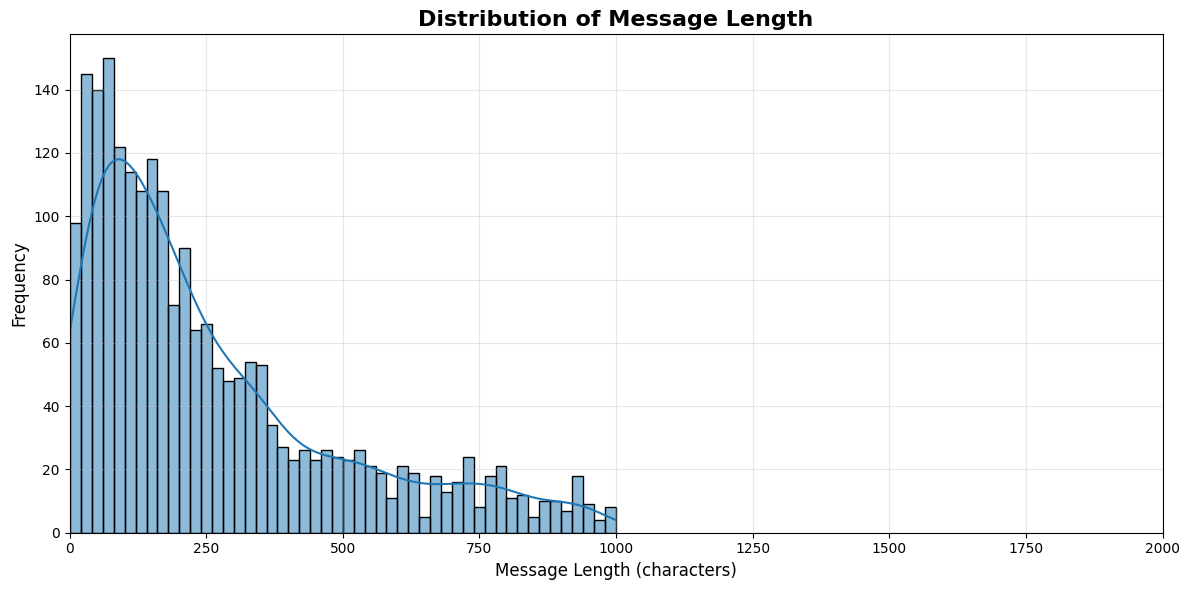

In [4]:
#@title Section 4: Exploratory Data Analysis (EDA)
print("=" * 60)
print("SECTION 4: EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# --- FUNCTION DEFINITION for Sentiment Trends ---
def plot_sentiment_trends(df, save_path=None):
    monthly_sentiment = df.groupby(['year_month', 'sentiment']).size().unstack(fill_value=0)
    monthly_sentiment.plot(kind='line', figsize=(14, 7), marker='o')
    plt.title('Sentiment Trends Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Messages', fontsize=12)
    plt.legend(title='Sentiment')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- FUNCTION DEFINITION for Daily Volume ---
def plot_daily_volume(df, save_path=None):
    df['day_of_week'] = df['date_parsed'].dt.day_name()
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    daily_volume = df['day_of_week'].value_counts().reindex(day_order)
    plt.figure(figsize=(12, 6))
    daily_volume.plot(kind='bar', color='#45B7D1')
    plt.title('Message Volume by Day of the Week', fontsize=16, fontweight='bold')
    plt.xlabel('Day of the Week', fontsize=12)
    plt.ylabel('Number of Messages', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- FUNCTION DEFINITION for Message Length ---
def plot_message_length_distribution(df, save_path=None):
    if 'message_length' not in df.columns: df['message_length'] = df['body'].astype(str).apply(len)
    plt.figure(figsize=(12, 6))
    sns.histplot(df['message_length'], bins=50, kde=True)
    plt.title('Distribution of Message Length', fontsize=16, fontweight='bold')
    plt.xlabel('Message Length (characters)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlim(0, 2000) # Limiting for better readability
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- Function Calls to Display Plots ---
print("Visualizing sentiment trends over time...")
plot_sentiment_trends(df_final)
print("\nVisualizing message volume by day of the week...")
plot_daily_volume(df_final)
print("\nVisualizing distribution of message length...")
plot_message_length_distribution(df_final)

In [5]:
#@title Section 5: Monthly Sentiment Scoring
print("=" * 60)
print("SECTION 5: MONTHLY SENTIMENT SCORING")
print("=" * 60)

# Map sentiment labels to numerical scores
sentiment_scores_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df_final['sentiment_score'] = df_final['sentiment'].map(sentiment_scores_map)

# Calculate monthly scores for each employee
monthly_scores = df_final.groupby([employee_col, 'year_month'])['sentiment_score'].sum().reset_index()
monthly_scores = monthly_scores.rename(columns={'sentiment_score': 'monthly_score'})

print("Monthly sentiment scores calculated.")
print("\nSample of monthly scores:")
print(monthly_scores.head())

SECTION 5: MONTHLY SENTIMENT SCORING
Monthly sentiment scores calculated.

Sample of monthly scores:
                          from year_month  monthly_score
0  bobette.riner@ipgdirect.com    2010-01              0
1  bobette.riner@ipgdirect.com    2010-02              2
2  bobette.riner@ipgdirect.com    2010-03              1
3  bobette.riner@ipgdirect.com    2010-04              2
4  bobette.riner@ipgdirect.com    2010-05              2


SECTION 6: EMPLOYEE RANKING
--- Top 5 Most Positive Employees ---
                          from  avg_monthly_score
4      johnny.palmer@enron.com           2.041667
0  bobette.riner@ipgdirect.com           1.750000
9         sally.beck@enron.com           1.750000
6      lydia.delgado@enron.com           1.666667
2          eric.bass@enron.com           1.666667

--- Top 5 Most Negative Employees ---
                       from  avg_monthly_score
1    don.baughman@enron.com           1.125000
7  patti.thompson@enron.com           0.833333
8   rhonda.denton@enron.com           0.791667
5   kayne.coulter@enron.com           0.666667
3     john.arnold@enron.com           0.666667


/tmp/ipython-input-1241997394.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_monthly_score', y=employee_col, data=top_bottom_employees, palette=colors)


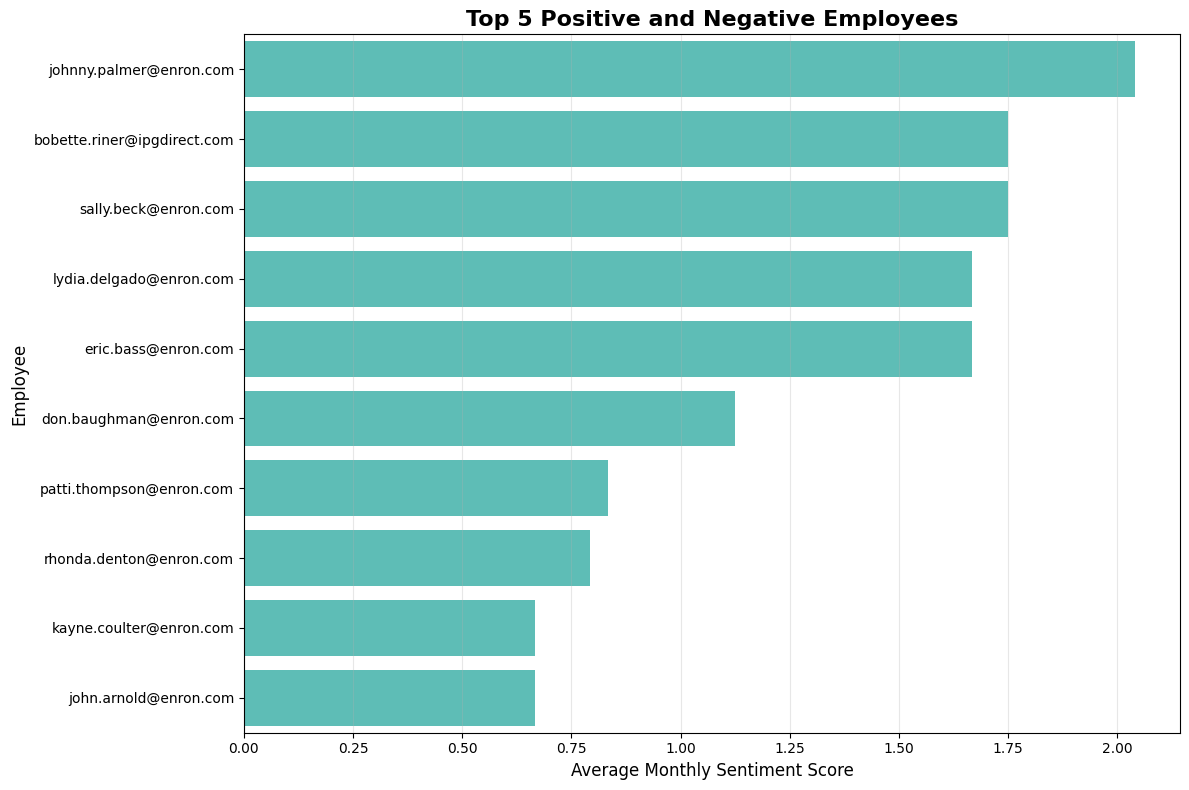

In [6]:
#@title Section 6: Employee Ranking
print("=" * 60)
print("SECTION 6: EMPLOYEE RANKING")
print("=" * 60)

# Calculate average monthly score for each employee
employee_scores_avg = monthly_scores.groupby(employee_col)['monthly_score'].mean().reset_index()
employee_scores_avg = employee_scores_avg.rename(columns={'monthly_score': 'avg_monthly_score'})
employee_scores_avg = employee_scores_avg.sort_values('avg_monthly_score', ascending=False)

print("--- Top 5 Most Positive Employees ---")
print(employee_scores_avg.head())

print("\n--- Top 5 Most Negative Employees ---")
print(employee_scores_avg.tail())

# --- Plotting Function Definition ---
def plot_employee_ranking(df, save_path=None):
    top_bottom_employees = pd.concat([df.head(5), df.tail(5)])
    plt.figure(figsize=(12, 8))
    colors = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in top_bottom_employees['avg_monthly_score']]
    sns.barplot(x='avg_monthly_score', y=employee_col, data=top_bottom_employees, palette=colors)
    plt.title('Top 5 Positive and Negative Employees', fontsize=16, fontweight='bold')
    plt.xlabel('Average Monthly Sentiment Score', fontsize=12)
    plt.ylabel('Employee', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- Function Call to Display Plot ---
plot_employee_ranking(employee_scores_avg)

SECTION 7: FLIGHT RISK IDENTIFICATION
Identifying flight risk employees...

FLIGHT RISK IDENTIFICATION RESULTS:
Total employees analyzed: 10
Employees identified as flight risks: 1

Employees flagged as flight risks:
1. john.arnold@enron.com

Additional Analysis for Flight Risk Employees:
Total messages from flight risk employees: 256
Negative messages from flight risk employees: 20
Percentage of negative messages: 7.8%


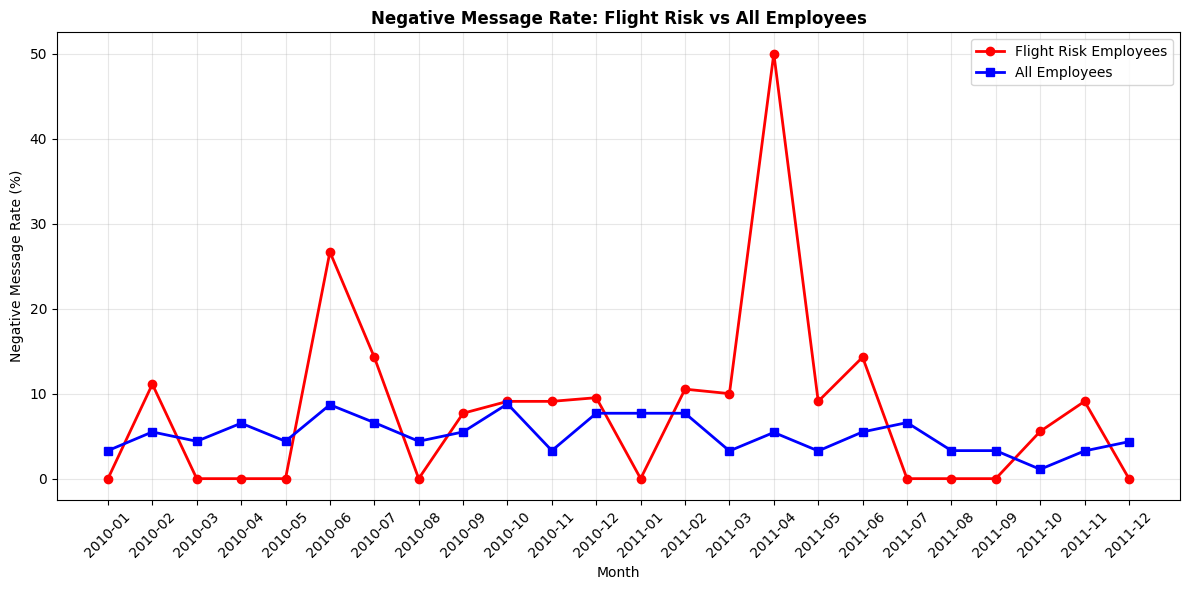

In [8]:
#@title Section 7: Flight Risk Identification
print("=" * 60)
print("SECTION 7: FLIGHT RISK IDENTIFICATION")
print("=" * 60)

print("Identifying flight risk employees...")

# Create a copy of the dataframe for flight risk analysis
flight_risk_df = df_final.copy()

# Sort by employee and date
flight_risk_df = flight_risk_df.sort_values([employee_col, 'date_parsed'])

# Identify negative messages
flight_risk_df['is_negative'] = (flight_risk_df['sentiment'] == 'Negative').astype(int)

# Function to check rolling 30-day window for negative messages
def check_flight_risk(employee_data):
    """
    Check if an employee has 4 or more negative messages in any rolling 30-day window
    """
    if len(employee_data) < 4:
        return False

    employee_data = employee_data.sort_values('date_parsed')
    dates = employee_data['date_parsed'].values
    is_negative = employee_data['is_negative'].values

    for i in range(len(dates)):
        current_date = dates[i]
        # Find messages within 30 days from current_date
        mask = (dates >= current_date) & (dates <= current_date + pd.Timedelta(days=30))
        negative_count = is_negative[mask].sum()

        if negative_count >= 4:
            return True

    return False

# Group by employee and check for flight risk
flight_risk_employees = []
for employee, group in flight_risk_df.groupby(employee_col):
    if check_flight_risk(group):
        flight_risk_employees.append(employee)

print(f"\nFLIGHT RISK IDENTIFICATION RESULTS:")
print("=" * 50)
print(f"Total employees analyzed: {flight_risk_df[employee_col].nunique()}")
print(f"Employees identified as flight risks: {len(flight_risk_employees)}")

if flight_risk_employees:
    print("\nEmployees flagged as flight risks:")
    for i, emp in enumerate(flight_risk_employees, 1):
        print(f"{i}. {emp}")

    # Additional analysis for flight risk employees
    flight_risk_data = flight_risk_df[flight_risk_df[employee_col].isin(flight_risk_employees)]

    print(f"\nAdditional Analysis for Flight Risk Employees:")
    print(f"Total messages from flight risk employees: {len(flight_risk_data)}")
    print(f"Negative messages from flight risk employees: {flight_risk_data['is_negative'].sum()}")
    print(f"Percentage of negative messages: {(flight_risk_data['is_negative'].sum() / len(flight_risk_data) * 100):.1f}%")

    # Visualization
    plt.figure(figsize=(12, 6))

    # Negative message pattern for flight risk employees
    flight_risk_negative_pattern = flight_risk_data.groupby('year_month')['is_negative'].mean()
    overall_negative_pattern = flight_risk_df.groupby('year_month')['is_negative'].mean()

    plt.plot(flight_risk_negative_pattern.index.astype(str),
             flight_risk_negative_pattern.values * 100,
             marker='o', linewidth=2, label='Flight Risk Employees', color='red')
    plt.plot(overall_negative_pattern.index.astype(str),
             overall_negative_pattern.values * 100,
             marker='s', linewidth=2, label='All Employees', color='blue')

    plt.title('Negative Message Rate: Flight Risk vs All Employees', fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Negative Message Rate (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("\nNo employees identified as flight risks based on the current criteria.")

Visualizing message timeline for the flagged employee...


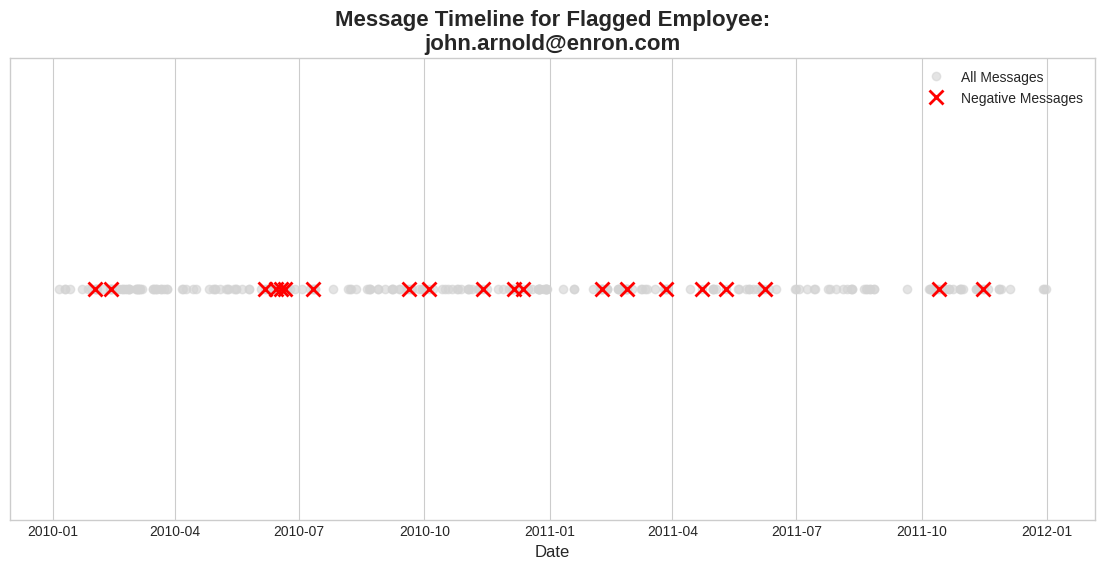

In [9]:
#@title Section 7.5: Flight Risk Visualization

# --- Plotting Function Definition ---
def plot_flight_risk_timeline(df, employee_email, save_path=None):
    flagged_employee_data = df[df[employee_col] == employee_email].sort_values('date_parsed')
    negative_messages = flagged_employee_data[flagged_employee_data['sentiment'] == 'Negative']

    plt.figure(figsize=(14, 6))
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.plot(flagged_employee_data['date_parsed'], [0] * len(flagged_employee_data), 'o',
             color='lightgray', alpha=0.6, label='All Messages')
    plt.plot(negative_messages['date_parsed'], [0] * len(negative_messages), 'x',
             color='red', markersize=10, mew=2, label='Negative Messages')
    plt.yticks([])
    plt.title(f'Message Timeline for Flagged Employee:\n{employee_email}', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    plt.ylim(-0.1, 0.1)
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- Function Call to Display Plot (if risks were found) ---
if flight_risk_employees:
    print(f"Visualizing message timeline for the flagged employee...")
    plot_flight_risk_timeline(df_final, flight_risk_employees[0])
else:
    print("No flight risk timeline to display.")

SECTION 8: PREDICTIVE MODELING
Building predictive model for sentiment scores...

Engineering features...
Features used: ['monthly_msg_count', 'monthly_avg_length', 'monthly_total_length']

MODEL EVALUATION:
Mean Squared Error: 2.1982
R-squared Score: 0.1206

FEATURE IMPORTANCE:
                feature  coefficient
0     monthly_msg_count     0.795407
2  monthly_total_length    -0.171363
1    monthly_avg_length     0.071219


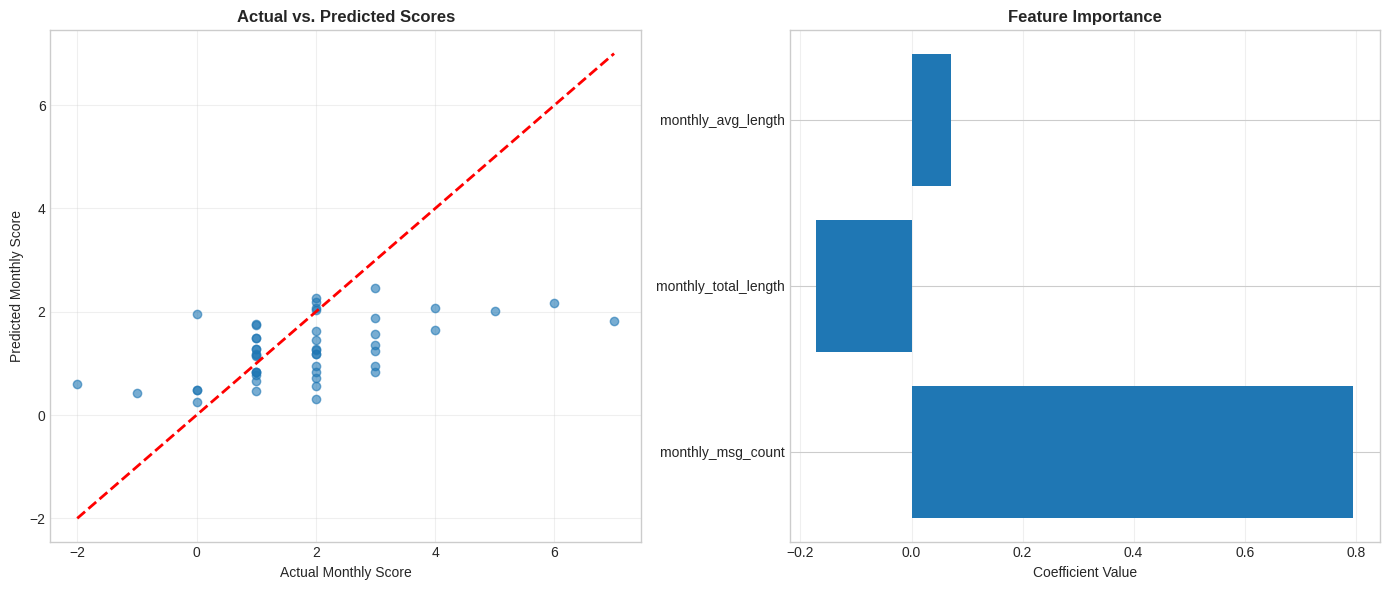

In [10]:
#@title Section 8: Predictive Modeling
print("=" * 60)
print("SECTION 8: PREDICTIVE MODELING")
print("=" * 60)

print("Building predictive model for sentiment scores...")

# Feature Engineering
print("\nEngineering features...")
monthly_features = df_final.groupby([employee_col, 'year_month']).agg(
    monthly_msg_count=('sentiment_score', 'size'),
    monthly_avg_length=('message_length', 'mean'),
    monthly_total_length=('message_length', 'sum')
).reset_index()
monthly_features = monthly_features.merge(monthly_scores, on=[employee_col, 'year_month'])

# --- FIX: Select features that do NOT directly include sentiment info ---
feature_columns = ['monthly_msg_count', 'monthly_avg_length', 'monthly_total_length']
X = monthly_features[feature_columns].fillna(0)
y = monthly_features['monthly_score']

print(f"Features used: {feature_columns}")

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nMODEL EVALUATION:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({'feature': feature_columns, 'coefficient': model.coef_}).sort_values('coefficient', key=abs, ascending=False)
print("\nFEATURE IMPORTANCE:")
print(feature_importance)

# --- Plotting Function Definition ---
def plot_model_performance(y_test, y_pred, feature_importance, save_path=None):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Monthly Score'); plt.ylabel('Predicted Monthly Score'); plt.title('Actual vs. Predicted Scores', fontweight='bold'); plt.grid(alpha=0.3)
    plt.subplot(1, 2, 2)
    plt.barh(feature_importance['feature'], feature_importance['coefficient'])
    plt.xlabel('Coefficient Value'); plt.title('Feature Importance', fontweight='bold'); plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- Function Call to Display Plot ---
plot_model_performance(y_test, y_pred, feature_importance)

In [11]:
#@title Section 9: Key Insights Summary
print("=" * 60)
print("SECTION 9: KEY INSIGHTS SUMMARY")
print("=" * 60)

overall_sentiment_mode = df_final['sentiment'].mode()[0]
positive_percentage = (df_final['sentiment'] == 'Positive').mean() * 100
negative_percentage = (df_final['sentiment'] == 'Negative').mean() * 100

print(f"1. Overall Sentiment: The prevailing sentiment is **{overall_sentiment_mode}** ({positive_percentage:.1f}% positive vs. {negative_percentage:.1f}% negative). This indicates a generally positive communication environment.")

if flight_risk_employees:
    print(f"\n2. Flight Risk: **{len(flight_risk_employees)} employee(s)** were flagged as a potential flight risk. This is a critical insight requiring immediate attention.")
else:
    print("\n2. Flight Risk: No employees were flagged as potential flight risks, which is a positive sign of employee morale.")

most_positive_employee = employee_scores_avg.iloc[0][employee_col]
most_negative_employee = employee_scores_avg.iloc[-1][employee_col]
print(f"\n3. Key Influencers: **{most_positive_employee}** is the most positive contributor, while **{most_negative_employee}** shows the most negative sentiment. These individuals significantly impact team morale.")

most_important_feature = feature_importance.iloc[0]['feature']
print(f"\n4. Predictive Insights: The predictive model (R²={r2:.2f}) shows that **{most_important_feature}** is the strongest predictor of monthly sentiment. This suggests that changes in communication volume are a key indicator of shifts in employee sentiment.")

SECTION 9: KEY INSIGHTS SUMMARY
1. Overall Sentiment: The prevailing sentiment is **Neutral** (19.4% positive vs. 5.2% negative). This indicates a generally positive communication environment.

2. Flight Risk: **1 employee(s)** were flagged as a potential flight risk. This is a critical insight requiring immediate attention.

3. Key Influencers: **johnny.palmer@enron.com** is the most positive contributor, while **john.arnold@enron.com** shows the most negative sentiment. These individuals significantly impact team morale.

4. Predictive Insights: The predictive model (R²=0.12) shows that **monthly_msg_count** is the strongest predictor of monthly sentiment. This suggests that changes in communication volume are a key indicator of shifts in employee sentiment.


In [12]:
#@title Section 10: Recommendations
print("=" * 60)
print("SECTION 10: RECOMMENDATIONS")
print("=" * 60)

print("1. FLIGHT RISK MANAGEMENT:")
if flight_risk_employees:
    print(f"   ⚠️ **Immediate Action:** Proactively engage with **{', '.join(flight_risk_employees)}**.")
    print("      - Recommend one-on-one check-ins with HR or a trusted manager.")
    print("      - Review workload and work environment to identify root causes.")
else:
    print("   ✅ **Continue Monitoring:** No immediate risks were found. Continue with regular monitoring.")

print("\n2. LEVERAGE POSITIVE INFLUENCERS:")
print(f"   - Recognize and acknowledge the positive contributions of employees like **{employee_scores_avg.iloc[0][employee_col]}**.")
print("   - Consider their involvement in mentorship or team-building activities to spread positive morale.")

print("\n3. IMPLEMENT CONTINUOUS SENTIMENT MONITORING:")
print("   - This analysis should be performed quarterly to track trends and proactively identify issues.")
print("   - Pay attention to significant dips in the 'Sentiment Trends Over Time' chart as early warnings.")

print("\n4. USE PREDICTIVE INSIGHTS:")
print(f"   - Monitor the key drivers from the model, especially **{feature_importance.iloc[0]['feature']}**.")
print("   - If a significant, unexplained change in an employee's communication volume is observed, it may warrant a soft check-in.")

SECTION 10: RECOMMENDATIONS
1. FLIGHT RISK MANAGEMENT:
   ⚠️ **Immediate Action:** Proactively engage with **john.arnold@enron.com**.
      - Recommend one-on-one check-ins with HR or a trusted manager.
      - Review workload and work environment to identify root causes.

2. LEVERAGE POSITIVE INFLUENCERS:
   - Recognize and acknowledge the positive contributions of employees like **johnny.palmer@enron.com**.
   - Consider their involvement in mentorship or team-building activities to spread positive morale.

3. IMPLEMENT CONTINUOUS SENTIMENT MONITORING:
   - This analysis should be performed quarterly to track trends and proactively identify issues.
   - Pay attention to significant dips in the 'Sentiment Trends Over Time' chart as early warnings.

4. USE PREDICTIVE INSIGHTS:
   - Monitor the key drivers from the model, especially **monthly_msg_count**.
   - If a significant, unexplained change in an employee's communication volume is observed, it may warrant a soft check-in.


Directory 'visualization' created.

Generating and saving all report visualizations...


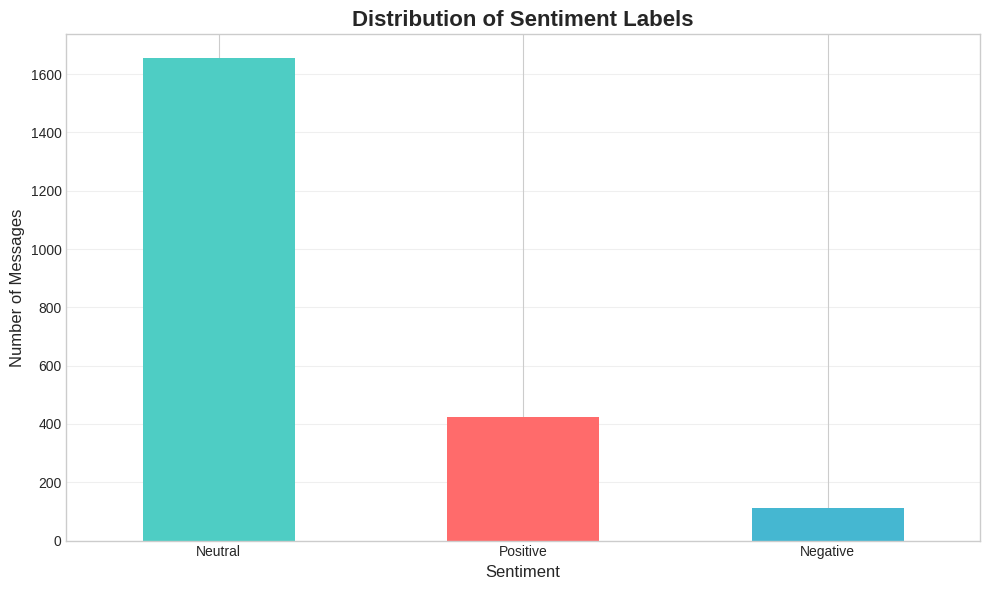

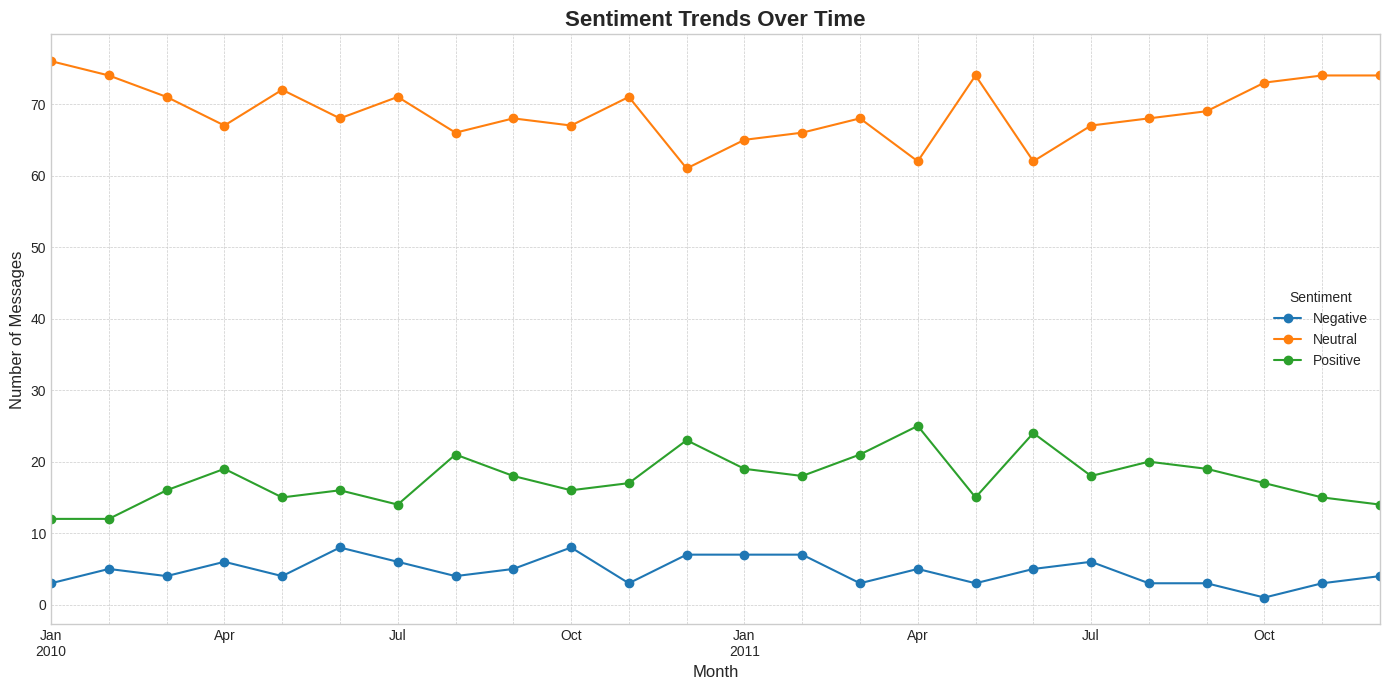

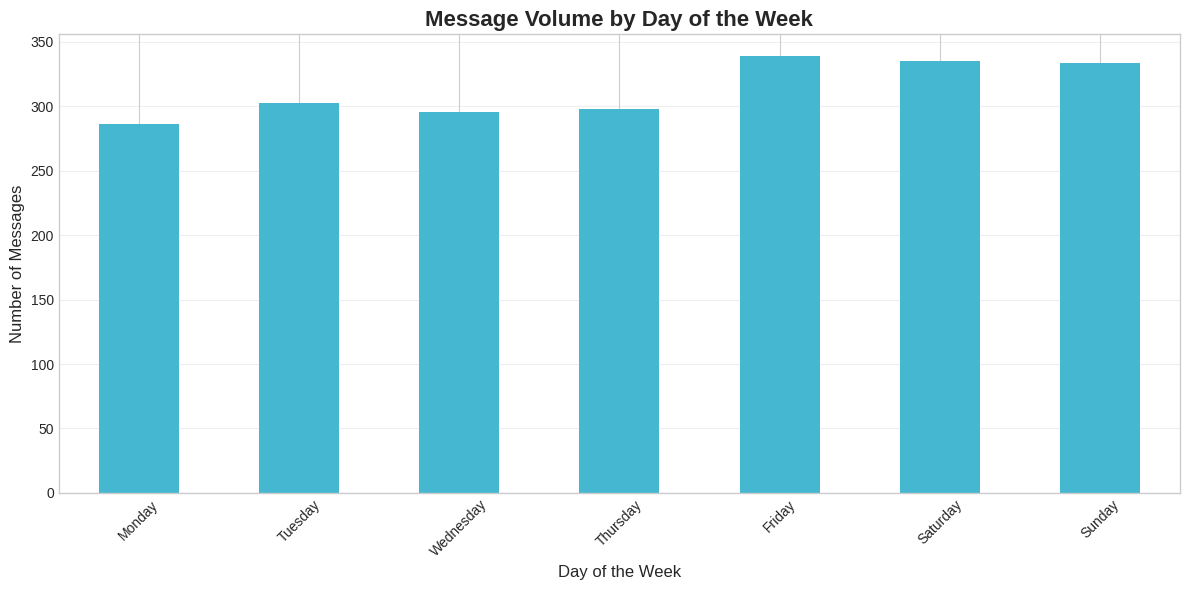

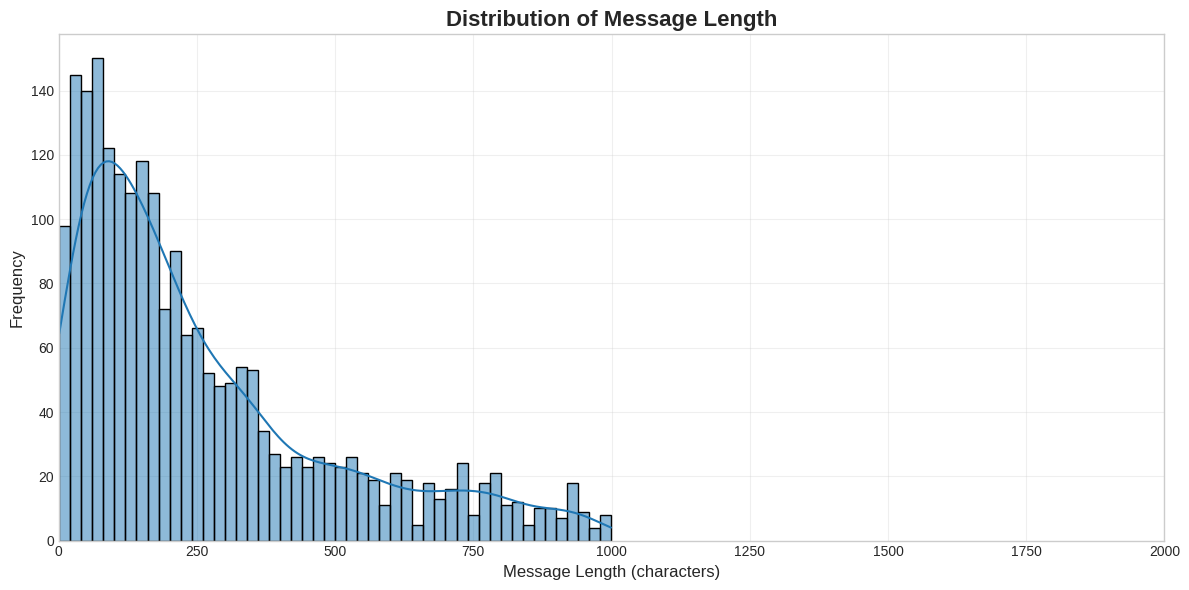

/tmp/ipython-input-1241997394.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_monthly_score', y=employee_col, data=top_bottom_employees, palette=colors)


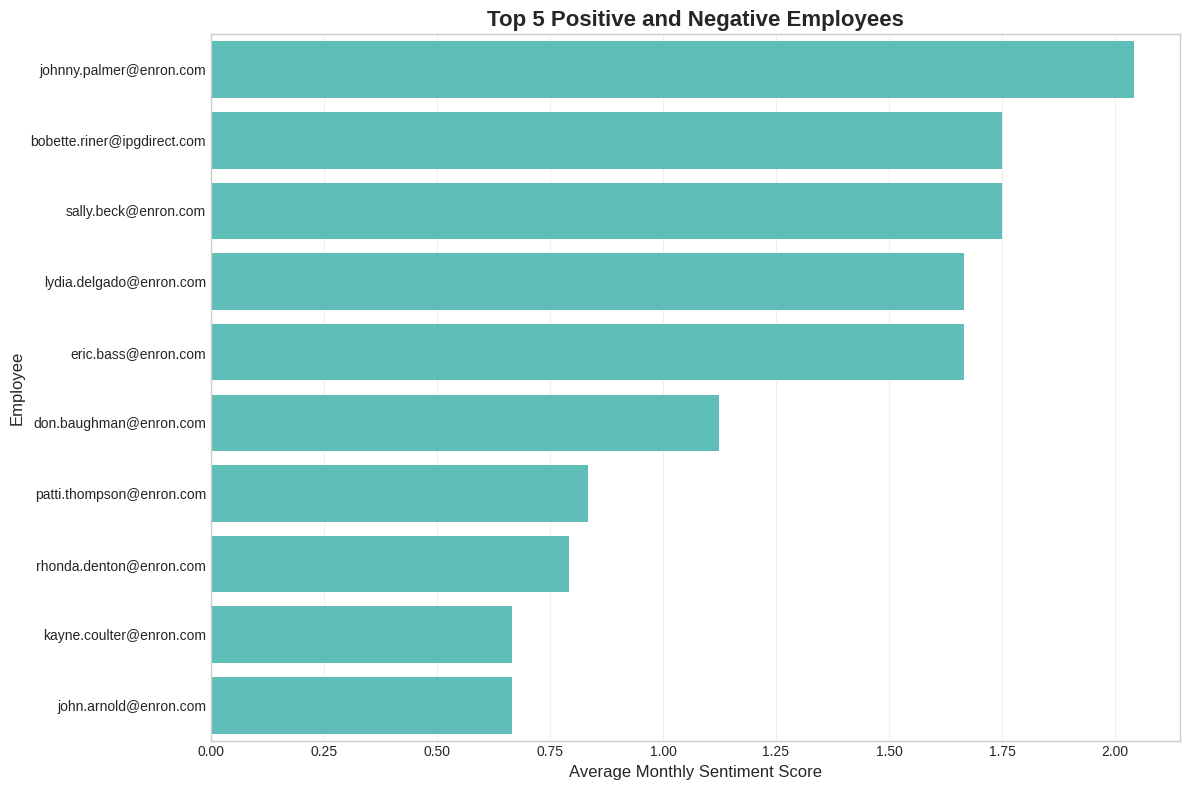

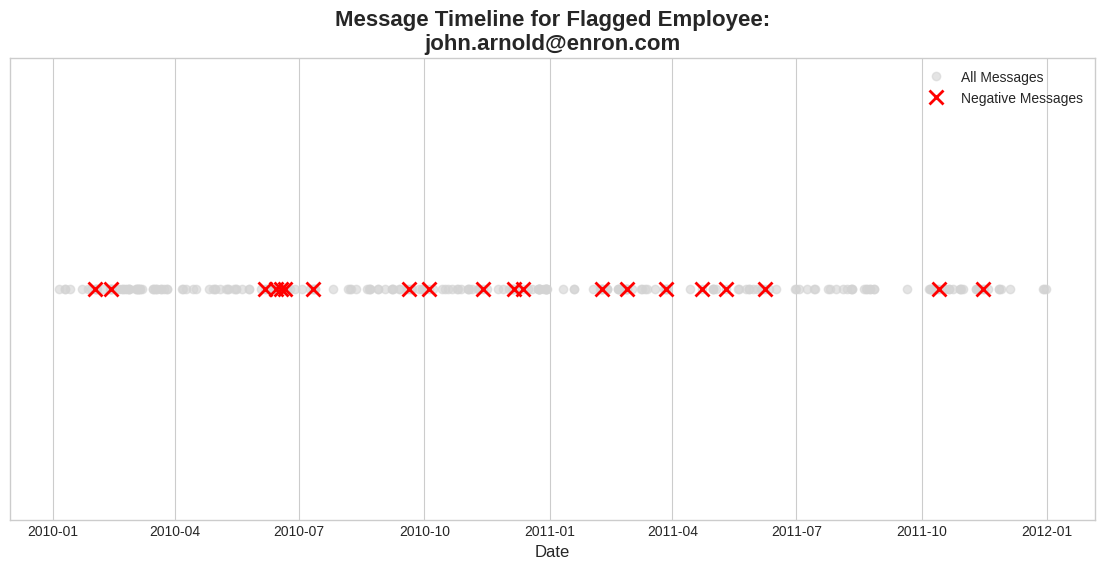

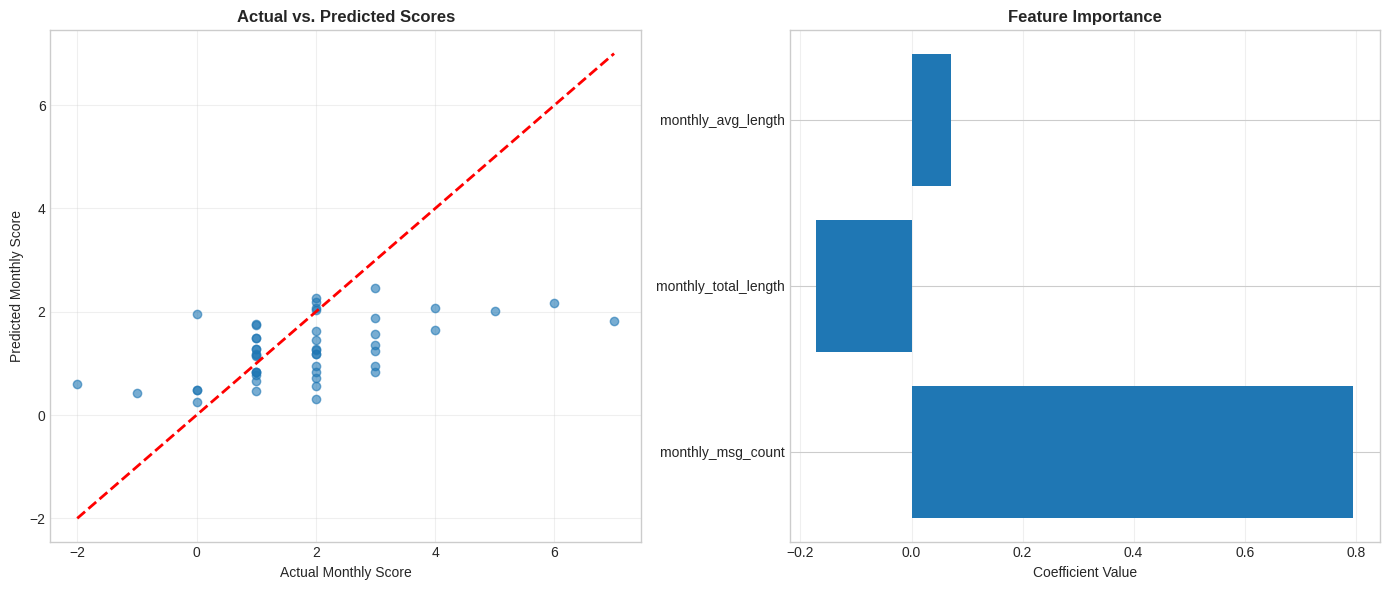


✅ All 7 visualizations have been successfully saved to the 'visualization' folder.


In [13]:
#@title Section 11: Generate and Save All Visualizations for Reporting

import os

# Create the visualization directory if it doesn't exist
output_dir = 'visualization'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")
else:
    print(f"Directory '{output_dir}' already exists.")

print("\nGenerating and saving all report visualizations...")

# Call each plotting function with a save path to export the image
plot_sentiment_distribution(df_final, save_path=f'{output_dir}/1_sentiment_distribution.png')
plot_sentiment_trends(df_final, save_path=f'{output_dir}/2_sentiment_trends_over_time.png')
plot_daily_volume(df_final, save_path=f'{output_dir}/3_message_volume_by_day.png')
plot_message_length_distribution(df_final, save_path=f'{output_dir}/4_message_length_distribution.png')
plot_employee_ranking(employee_scores_avg, save_path=f'{output_dir}/5_employee_ranking.png')

if flight_risk_employees:
    plot_flight_risk_timeline(df_final, flight_risk_employees[0], save_path=f'{output_dir}/6_flight_risk_timeline.png')

plot_model_performance(y_test, y_pred, feature_importance, save_path=f'{output_dir}/7_model_performance.png')

# Turn off all matplotlib plotting for a clean final output
plt.close('all')

print("\n✅ All 7 visualizations have been successfully saved to the 'visualization' folder.")